# АНАЛИЗ КОНВЕРСИЙ ПО БАЗЕ ДАННЫХ ТИНЬКОФФ-КВЕСТ

Импортируем необходимые библиотеки

In [180]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from plotly import graph_objects as go

In [181]:
pip install psycopg2

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Подключаемся к базе данных:

In [192]:
import psycopg2
connection = psycopg2.connect(database="postgres", user="student", password="JvLda93aA", host="158.160.52.106", port="5432")
cursor = connection.cursor()

Посчитаем по месяцам, сколько клиентов посещает наш сайт, и какая доля из них регистрируется на нем \ подает заявку на игру \ по факту приходит на неё:

In [183]:
cursor.execute(
'''
select 
 mm, 
 count(client) as visit_cnt, 
 count(account) as account_cnt, 
 sum(application) as app_cnt,
 sum(game) as game_cnt
from
 (select 
   to_char(visit_dttm, 'YYYY-MM') as mm,
   msu_analytics.client.client_rk as client, 
   msu_analytics.account.account_rk as account, 
   case when exists(select 1 from msu_analytics.application 
   	 where msu_analytics.account.account_rk = msu_analytics.application.account_rk) 
   	 then 1 else 0 end as application,
   case when exists(select 1 from msu_analytics.game 
     inner join msu_analytics.application on msu_analytics.application.game_rk = msu_analytics.game.game_rk
     where msu_analytics.game.game_flg = 1 and msu_analytics.account.account_rk = msu_analytics.application.account_rk) 
     then 1 else 0 end as game
 from msu_analytics.client
 left join msu_analytics.account on msu_analytics.client.client_rk = msu_analytics.account.client_rk
 ) as q
group by mm
order by mm
''')
result = cursor.fetchall()

In [184]:
result

[('2022-09', 778, 190, 51, 39),
 ('2022-10', 843, 217, 65, 56),
 ('2022-11', 786, 200, 56, 50),
 ('2022-12', 805, 196, 57, 33),
 ('2023-01', 852, 213, 64, 20),
 ('2023-02', 32, 8, 0, 0)]

In [185]:
data = pd.DataFrame(result)
data

,0,1,2,3,4
0,2022-09,778,190,51,39
1,2022-10,843,217,65,56
2,2022-11,786,200,56,50
3,2022-12,805,196,57,33
4,2023-01,852,213,64,20
5,2023-02,32,8,0,0


Посчитаем собственно доли от общего числа визитов на сайт, выразим в процентах:

In [186]:
proc = [(100 * data[i + 2] / data[1]).astype(int).astype(str) + "%" for i in range(3)]

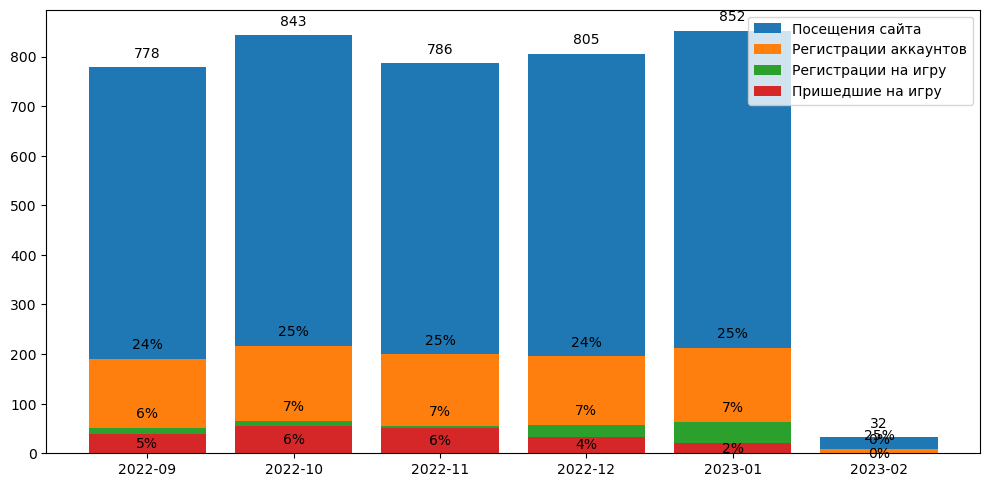

In [187]:
fig, ax = plt.subplots(figsize=(10, 5))
x = np.array(data.index.tolist())
rects1 = ax.bar(x, data[1], label='Посещения сайта')
rects2 = ax.bar(x, data[2], label='Регистрации аккаунтов')
rects3 = ax.bar(x, data[3], label='Регистрации на игру')
rects4 = ax.bar(x, data[4], label='Пришедшие на игру')
ax.set_xticks(x)
ax.set_xticklabels(data[0])
ax.legend()
ax.bar_label(rects1, padding=5)
ax.bar_label(rects2, labels = proc[0], padding=5)
ax.bar_label(rects3, labels = proc[1], padding=5)
ax.bar_label(rects4, labels = proc[2], label_type='center')
fig.tight_layout()

### ПОЯСНЕНИЕ: здесь высота столбика отражает общее число людей, посетивших сайт. То есть чисто синим цветом покрашены уже те, кто посетил, но не зарегистрировался. Оранжевым - посетил и зарегистрировался, но не записался на игру. Зелёным - записался на игру, но не пришёл. Красным - те, кто пришёл на игру.

### А дальше доли указаны от общего числа посещений.

## То есть здесь не надо как-то пытаться понять, сколько было чисто синих для количества посещений. Нет, вот высота столбика это и есть количество посещений. Дальше смотрим высоту оранжевого - это и есть количество регистраций. А в процентах подписаны доли от посетителей сайта

Давайте теперь построим воронку, чтобы посмотреть не процент от изначальных визитов на сайте, а какой процент клиентов проходит дальше на каждом уровне. Давайте сначала посмотрим все месяцы на одном графике и значения по этой воронке, а потом можно какой-то месяц исследовать отдельно.

In [188]:
fig = go.Figure()

for index, row in data.iterrows():
    fig.add_trace(go.Funnel(
        name = data[0][index],
        y = ["", "Посещения сайта", "Регистрации аккаунтов", "Регистрации на игру", "Пришедшие на игру"],
        x = row,
        textinfo = "value+percent previous"))
    
fig.update_layout(
    autosize=False,
    width=1500,
    height=1000
)    

fig.show()

#### Месяцы идентичны почти везде, кроме последнего шага "регистрации на игру - пришедшие на игру": там отличаются проценты пришедших на игру по месяцам. Посмотрим отдельно на воронку этого шага:

In [203]:
fig = go.Figure()

for index, row in data.iterrows():
    fig.add_trace(go.Funnel(
        name = data[0][index],
        y = ["Регистрации на игру", "Пришедшие на игру"],
        x = row[3:],
        textinfo = "value+percent previous"))
    
fig.update_layout(
    autosize=False,
    width=700,
    height=500
)    

fig.show()

#### Можно объяснить тем, что декабрьские и январские пользователи только недавно узнали о квестах и ещё не успели сходить на игру. 

###### А почему в сентябре меньше? Видимо, тогда проект только запускался и мало клиентов хотели сразу же на него идти - не было отзывов, рекомендаций знакомых и т.п.

# Теперь сделаем анализ не по месяцам, а по неделям

Можно было бы брать запросы по YYYY-WW, то есть по номеру недели. Но тут возникнет проблема с тем, что в декабре в последней неделе дней меньше. И получилась бы странная аналитика. Поэтому сделаем получше: будем брать по 7 дней и округлять значение даты до первого дня недели

In [193]:
cursor.execute(
'''
select 
 to_char(date '2022-09-01' + dd * 7, 'DD.MM') as d, 
 count(client) as visit_cnt, 
 count(account) as account_cnt, 
 sum(application) as app_cnt,
 sum(game) as game_cnt
from
 (select 
   cast(DATE_PART('day', visit_dttm - '2022-09-01 00:00:00'::timestamp) as INTEGER) / 7 as dd,
   msu_analytics.client.client_rk as client, 
   msu_analytics.account.account_rk as account, 
   case when exists(select 1 from msu_analytics.application 
   	 where msu_analytics.account.account_rk = msu_analytics.application.account_rk) 
   	 then 1 else 0 end as application,
   case when exists(select 1 from msu_analytics.game 
     inner join msu_analytics.application on msu_analytics.application.game_rk = msu_analytics.game.game_rk
     where msu_analytics.game.game_flg = 1 and msu_analytics.account.account_rk = msu_analytics.application.account_rk) 
     then 1 else 0 end as game
 from msu_analytics.client
 left join msu_analytics.account on msu_analytics.client.client_rk = msu_analytics.account.client_rk
 ) as q
group by dd
order by dd
''')
week_result = cursor.fetchall()

In [194]:
week_result

[('01.09', 178, 46, 10, 7),
 ('08.09', 196, 40, 13, 10),
 ('15.09', 164, 37, 10, 5),
 ('22.09', 183, 55, 16, 15),
 ('29.09', 207, 56, 19, 18),
 ('06.10', 209, 52, 10, 8),
 ('13.10', 157, 41, 14, 13),
 ('20.10', 182, 45, 12, 10),
 ('27.10', 209, 50, 15, 12),
 ('03.11', 173, 46, 17, 15),
 ('10.11', 182, 40, 10, 8),
 ('17.11', 178, 46, 13, 12),
 ('24.11', 189, 53, 13, 12),
 ('01.12', 165, 40, 10, 8),
 ('08.12', 177, 44, 18, 13),
 ('15.12', 190, 48, 13, 5),
 ('22.12', 196, 45, 12, 5),
 ('29.12', 187, 48, 14, 4),
 ('05.01', 202, 59, 17, 7),
 ('12.01', 199, 37, 9, 2),
 ('19.01', 191, 47, 14, 7),
 ('26.01', 177, 47, 14, 2),
 ('02.02', 5, 2, 0, 0)]

In [195]:
week_data = pd.DataFrame(week_result)
week_data

,0,1,2,3,4
0,01.09,178,46,10,7
1,08.09,196,40,13,10
2,15.09,164,37,10,5
3,22.09,183,55,16,15
4,29.09,207,56,19,18
5,06.10,209,52,10,8
6,13.10,157,41,14,13
7,20.10,182,45,12,10
8,27.10,209,50,15,12
9,03.11,173,46,17,15


In [196]:
week_proc = [(100 * week_data[i + 2] / week_data[1]).astype(int).astype(str) + "%" for i in range(3)]

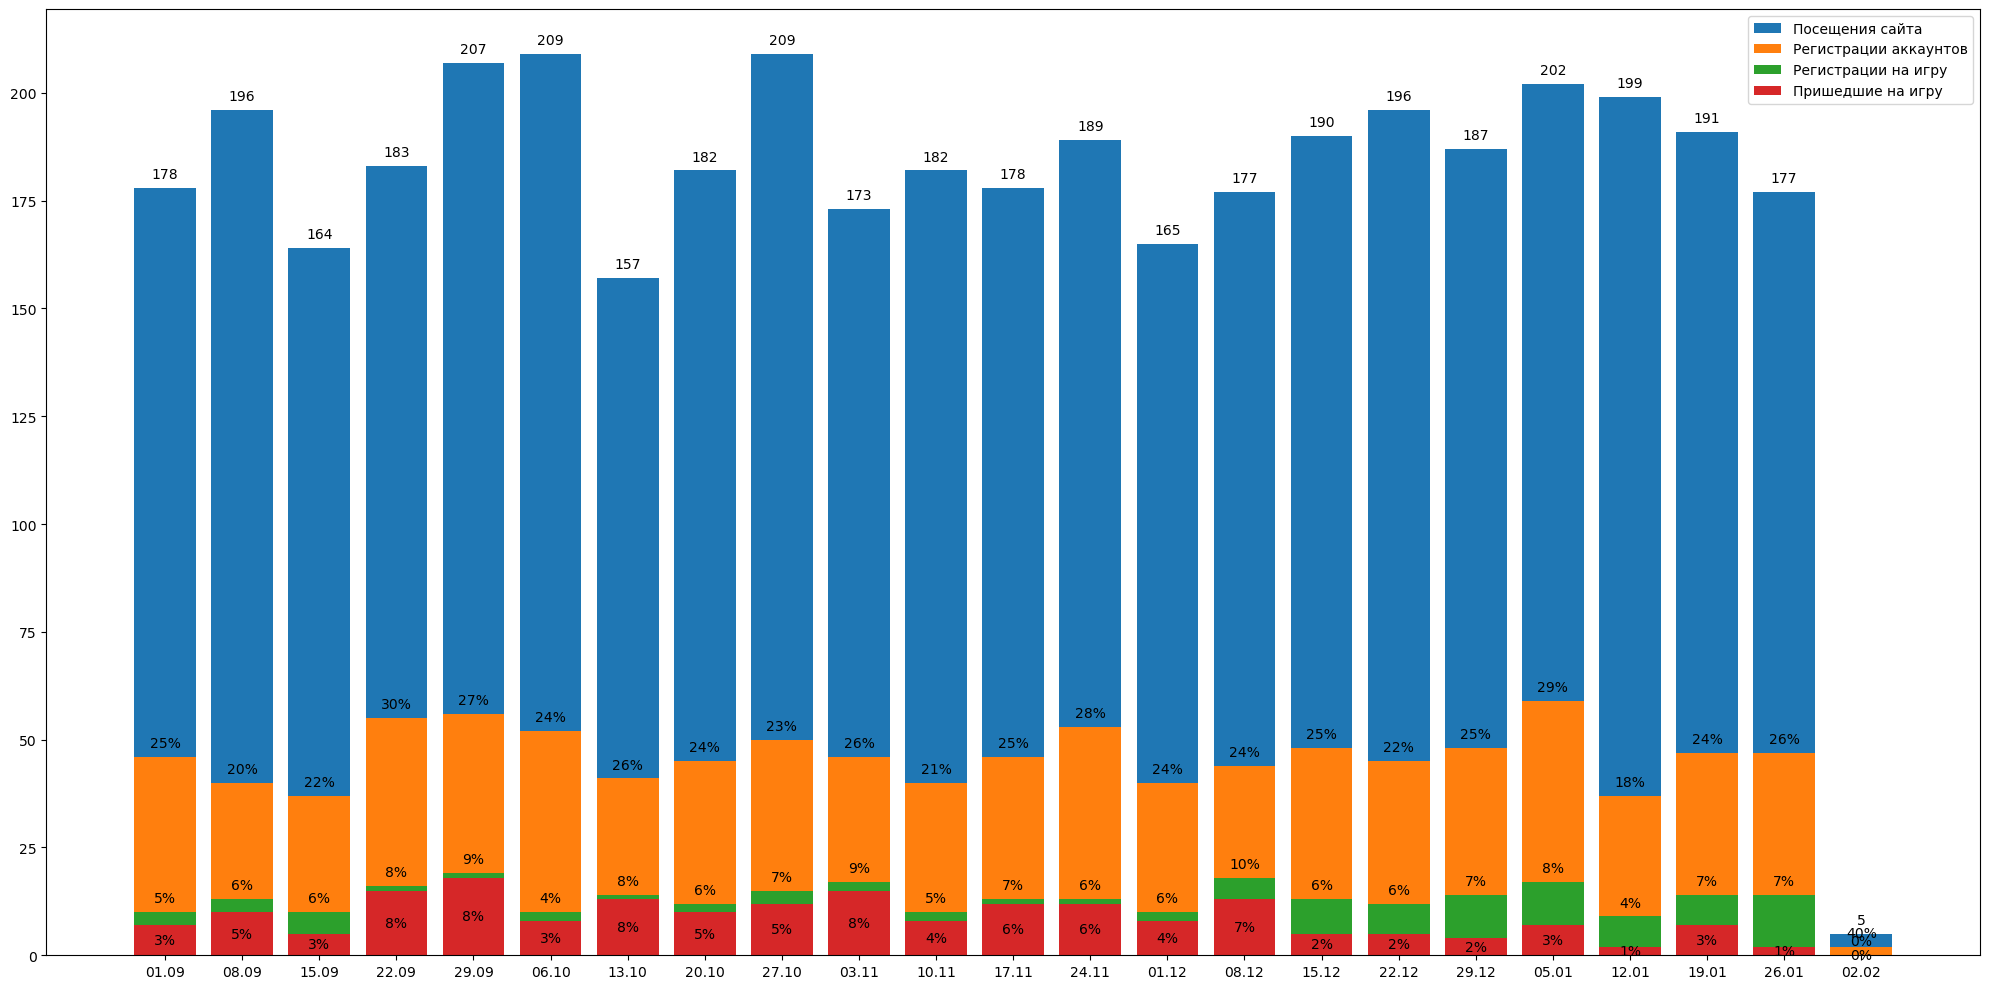

In [202]:
fig, ax = plt.subplots(figsize=(20, 10))
x = np.array(week_data.index.tolist())
rects1 = ax.bar(x, week_data[1], label='Посещения сайта')
rects2 = ax.bar(x, week_data[2], label='Регистрации аккаунтов')
rects3 = ax.bar(x, week_data[3], label='Регистрации на игру')
rects4 = ax.bar(x, week_data[4], label='Пришедшие на игру')
ax.set_xticks(x)
ax.set_xticklabels(week_data[0])
ax.legend()
ax.bar_label(rects1, padding=5)
ax.bar_label(rects2, labels = week_proc[0], padding=5)
ax.bar_label(rects3, labels = week_proc[1], padding=5)
ax.bar_label(rects4, labels = week_proc[2], label_type='center')
fig.tight_layout()

### ПОЯСНЕНИЕ: здесь высота столбика отражает общее число людей, посетивших сайт. То есть чисто синим цветом покрашены уже те, кто посетил, но не зарегистрировался. Оранжевым - посетил и зарегистрировался, но не записался на игру. Зелёным - записался на игру, но не пришёл. Красным - те, кто пришёл на игру.

### А дальше доли указаны от общего числа посещений.

## То есть здесь не надо как-то пытаться понять, сколько было чисто синих для количества посещений. Нет, вот высота столбика это и есть количество посещений. Дальше смотрим высоту оранжевого - это и есть количество регистраций. А в процентах подписаны доли от посетителей сайта

Теперь посмотрим воронки конверсий на каждом шаге:

In [199]:
fig = go.Figure()

for index, row in week_data.iterrows():
    fig.add_trace(go.Funnel(
        name = week_data[0][index],
        y = ["", "Посещения сайта", "Регистрации аккаунтов", "Регистрации на игру", "Пришедшие на игру"],
        x = row[1:3],
        textinfo = "value+percent previous"))
    
fig.update_layout(
    autosize=False,
    width=1500,
    height=500
)    

fig.show()

In [200]:
fig = go.Figure()

for index, row in week_data.iterrows():
    fig.add_trace(go.Funnel(
        name = week_data[0][index],
        y = ["Регистрации аккаунтов", "Регистрации на игру", "Пришедшие на игру"],
        x = row[2:4],
        textinfo = "value+percent previous"))

fig.update_layout(
    autosize=False,
    width=1500,
    height=500
)    

fig.show()

In [201]:
fig = go.Figure()

for index, row in week_data.iterrows():
    fig.add_trace(go.Funnel(
        name = week_data[0][index],
        y = ["Регистрации на игру", "Пришедшие на игру"],
        x = row[3:],
        textinfo = "value+percent previous"))

fig.show()

# Выводы, возможные точки роста продукта

1) Количество посещений сайта в норме. Когда только запустились в сентябре, было поменьше визитов. Потом пошёл рост, в ноябре и декабре чуть просели, но с января снова растёт интерес пользователей

2) Каждый четвёртый посетитель регистрирует аккаунт на сайте. Этот ориентир стабилен всё время с начала игр

3) Каждый четвёртый из тех, кто зарегистрировал аккаунт, записывается на игру. Этот показатель колеблется, но в целом тут нет чёткой динамики

4) Из тех, кто записался на игру, раньше приходило 80-90 процентов. Но с декабря этот показатель в районе 70%, а в январе и вовсе на уровне 30%. Можно подумать, что декабрьские и январские ещё не успели прийти на игру, ведь у нас данные до февраля, НО!

Количество регистраций ведь на том же уровне, количество записей на игру на том же уровне. А вот приходить почему-то стали реже. Вряд ли много людей записываются на игру через месяц или через два, обычно планируют в среднем на неделю вперёд. Значит, что-то не так стало. Может быть, перестали приходить напоминалки про игру

Соответственно надо как-то стимулировать играть почти всех, кто зарегался на игру (понятно, кроме болезни там и обстоятельств, но это процентов 10). Нужно присылать на почту или по SMS напоминалку о предстоящей игре. Скажем, за сутки на почту и за три часа до игры по SMS. Ещё, может быть, сделать вариант, что отменить запись можно не раньше, чем за три часа до игры, и вот в напоминании прислать, что если планы изменились, то стоит сказать сейчас, иначе всё - поздняк метаться. Чтобы не получалось так, что у нас игры простаивают или отменяются, когда люди в последний момент передумали и не пришли